In [13]:
# loading needed methods
import warnings
warnings.filterwarnings("ignore")


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm
from random import seed,sample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, roc_curve, auc,\
precision_score
from sklearn.ensemble import RandomForestClassifier


In [17]:
dataset1.to_csv('backup.csv', encoding='utf-8', index = 'false')

In [18]:
# finalizing dataset
dataset = pd.read_csv('backup.csv') # unchanged dataset1

In [20]:
dataset.head()

,Unnamed: 0,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,errorBalanceOrg,errorBalanceDest,HourOfDay,type_CASH_OUT,type_TRANSFER
0,2,1,181.00,181.0,0.0,0.0,0.00,1,0.00,181.0,1,0,1
1,3,1,181.00,181.0,0.0,21182.0,0.00,1,0.00,21363.0,1,1,0
2,15,1,229133.94,15325.0,0.0,5083.0,51513.44,0,213808.94,182703.5,1,1,0
3,19,1,215310.30,705.0,0.0,22425.0,0.00,0,214605.30,237735.3,1,0,1
4,24,1,311685.89,10835.0,0.0,6267.0,2719172.89,0,300850.89,-2401220.0,1,0,1


In [21]:
len(dataset[dataset['isFraud']==1])

8213

In [22]:
from imblearn.under_sampling import NearMiss

In [26]:
X = dataset.drop("isFraud",1)
y = dataset.isFraud

In [27]:
# Implementing Undersampling for Handling Imbalanced 
nm = NearMiss()
X_res,y_res=nm.fit_sample(X,y)

In [28]:
from collections import Counter
print('Original dataset shape {}'.format(Counter(y)))
print('Resampled dataset shape {}'.format(Counter(y_res)))

Original dataset shape Counter({0: 2762196, 1: 8213})
Resampled dataset shape Counter({0: 8213, 1: 8213})


In [29]:

RandomState = 42
seed(21)

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.45, random_state=42)
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [30]:
X_train = X_train[y_train==0] #T-plus
y_train = y_train[y_train==0]

In [31]:
X_test.shape[0]==y_test.shape[0]

True

In [32]:
import pywt
import math 
import numpy as np
from sklearn.model_selection import KFold

In [33]:
db1 = pywt.Wavelet('haar')

In [34]:
def getCosine(v1,v2):
    rad = np.dot(v1,v2)/(np.linalg.norm(v1)*np.linalg.norm(v2))
    return math.cos(rad)

In [35]:
def dwt_eval(X_train,y_train,t,alpha):
    t1,t2 = np.array(pywt.dwt(t, db1))
    v1=np.append(t1,t2)
    cos = 0
    ty_, X, y_d1, y_d2 = train_test_split(X_train, y_train, test_size=0.0001)
    for T in X:
        x1, x2 = np.array(pywt.dwt(T,db1))
        v2=np.append(x1,x2)
        cos = cos + getCosine(v1,v2)
    avg = cos/len(X)
    if avg > alpha:
        return 0
    else:
        return 1

In [36]:
def cal_alpha(X):
    sum_cos = 0
    map_ang = []
    for t1 in X:
        ang = 0
        for t2 in X:
            tx1,tx2 = np.array(pywt.dwt(t1, db1))
            v1=np.append(tx1,tx2)
            ty1,ty2 = np.array(pywt.dwt(t2, db1))
            v2=np.append(ty1,ty2)
            cos = getCosine(v1,v2)
            ang = ang + cos
            
        map_ang.append(ang/len(X))
        sum_cos = sum_cos + ang/len(X)
            
    alpha = sum_cos/len(X)
    return alpha,map_ang

In [37]:
def fit(X_test,X_train,y_train,alpha):
    y=[]
    for t in X_test:
        y.append(dwt_eval(X_train,y_train,t,alpha))
    return y

In [38]:
def get_alpha(X,n_splits):
    kf = KFold(n_splits)
    map_ang = []
    kf.get_n_splits(X)
    alp = 0
    i = 0
    for _, index in kf.split(X):
        Xt = X[index]
        cos = cal_alpha(Xt)
        map_ang.append(cos)
        alp += cos
        i = i + 1
    avg = alp/i
    return avg


In [39]:
def rel(y_test,y_pred):
    predictionsRFR=np.array(y_pred,dtype='int') 
    CM_RFR = confusion_matrix(y_test,predictionsRFR)
    CR_RFR = classification_report(y_test,predictionsRFR)
    fprRFR, recallRFR, thresholdsRFR = roc_curve(y_test, predictionsRFR)
    AUC_RFR = auc(fprRFR, recallRFR)
    print("=============<>==================\n")
    resultsRFR = {"Confusion Matrix":CM_RFR,"Classification Report":CR_RFR,"Area Under Curve":AUC_RFR}
    for measure in resultsRFR:
        print(measure,": \n",resultsRFR[measure])
    print("=============<>==================\n")

In [40]:
def predict(X_test,y_test,X_train,y_train,alpha):
    kf = KFold(500)
    kf.get_n_splits(X_test)
    yt = []
    y_test = np.array(y_test)
    i = 0
    for _, index in kf.split(X_test):
        X = X_test[index]
        y_ac = y_test[index]
        print("=>batch ",i," started\n")
        i = i+1
        y = fit(X,X_train,y_train,alpha)
        rel(y_ac,y)
        yt.append(y)
    return yt

In [41]:
y_train.shape

(4535,)

In [42]:
# n_splits=50
# alpha = get_alpha(X_train,n_splits)
alpha, feq_leg = cal_alpha(X_train)
# alpha = 0.7533006311996979

In [53]:
X_fraud = np.array(X_res[y_res==1]) #T-plus
y_fraud = np.array(y_res[y_res==1])

In [ ]:
alpha2, feq_fraud = cal_alpha(X_fraud)

In [48]:
#feq1=feq
xis=len(feq_leg)

In [49]:
xi=np.arange(0,xis,1)

In [50]:
len(xi)==len(feq_leg)

True

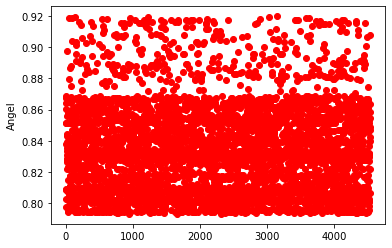

In [51]:
plt.plot(xi,feq_leg,'ro')
plt.ylabel('Angel')
plt.show()

In [ ]:
 alpha=0.8589585588178749

In [ ]:
X_test.shape

In [ ]:
print('Original dataset shape {}'.format(Counter(y_train)))

In [ ]:
y_pred = fit(X_test,X_train,y_train,alpha)
rel(y_test,y_pred)

In [ ]:
predictionsRFR=np.array(y_pred,dtype='int') 
     

CM_RFR = confusion_matrix(y_test,predictionsRFR)
CR_RFR = classification_report(y_test,predictionsRFR)
fprRFR, recallRFR, thresholdsRFR = roc_curve(y_test, predictionsRFR)
AUC_RFR = auc(fprRFR, recallRFR)

resultsRFR = {"Confusion Matrix":CM_RFR,"Classification Report":CR_RFR,"Area Under Curve":AUC_RFR}
for measure in resultsRFR:
    print(measure,": \n",resultsRFR[measure])

In [ ]:
db1 = pywt.Wavelet('haar')

In [ ]:
t = [3, 7, 1, 1, -2, 5, 4, 6]
T = [3, 5, 6, 1, 4, 5, 1, 2]

v1 = np.array(pywt.dwt(t, db1))

v2 = np.array(pywt.dwt(T,db1))

rad = np.dot(v1,v2)/(np.linalg.norm(v1)*np.linalg.norm(v2))
math.cos(rad)

In [ ]:
len(X_test)

In [ ]:
import numpy as np
from sklearn.model_selection import KFold
X = np.array([[1, 2], [3, 4], [1, 2], [3, 4]])
y = np.array([1, 2, 3, 4])
kf = KFold(n_splits=4)
kf.get_n_splits(X)

print(kf)

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    print(X_test)



In [ ]:
y_test

In [ ]:
ty_, X, y_d1, y_d2 = train_test_split(X_train, y_train, test_size=0.001)

In [ ]:
X.shape

In [ ]:
X